In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import bitstring
from qiskit_aer import AerSimulator
from qiskit.transpiler.passes.synthesis import SolovayKitaev
from qiskit.synthesis import generate_basic_approximations
from qiskit.quantum_info import Operator

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.circuit.library import UnitaryGate

In [86]:
#algorithm for that shit        ,       n=null, e=eins

nn = ["0000","1111"]
ne = ["0011","1100"]
en = ["0101","1010"]
ee = ["0110","1001"]

def idk(new: list, a: list, b:list, c:list):
    for i in a:
        for j in b:
            for k in c:
                new.append(i+j+k)

#noisefree gates
matrix_h = ([[2**(-0.5),2**(-0.5)],[2**(-0.5),-2**(-0.5)]])
h_ideal = UnitaryGate(matrix_h)

matrix_cx = ([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
cx_ideal = UnitaryGate(matrix_cx)       #Erst Target, dann Control Qubit!!

matrix_x = ([[0,1],[1,0]])
x_ideal = UnitaryGate(matrix_x)

matrix_z = ([[1,0],[0,-1]])
z_ideal = UnitaryGate(matrix_z)

In [ ]:
def code():                                     #intialize |00> state
    qr = QuantumRegister(15,"q")
    cbits = ClassicalRegister(29,"c")             #12(Auslesen am Ende) + 7(Preselection) + 5(Stabilizers) = 24 insgesamt
    qc = QuantumCircuit(qr, cbits)

    q = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

    for i in range(12):
        qc.id(i)

    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(7)
    qc.h(11)
    qc.h(12)

    qc.cx(12,3)
    qc.cx(7,13)
    qc.cx(11,14)


    qc.cx(0,3)
    qc.cx(1,3)
    qc.cx(2,3)

    qc.cx(7,4)
    qc.cx(7,5)
    qc.cx(7,6)

    qc.cx(11,8)
    qc.cx(11,9)
    qc.cx(11,10)

    qc.cx(12,3)
    qc.cx(7,13)
    qc.cx(11,14)

    qc.h(12)
    qc.id(12)
    qc.measure(12,0)
    qc.id(13)
    qc.measure(13,1)
    qc.id(14)
    qc.measure(14,2)

    qc.reset(12)
    qc.reset(13)
    qc.reset(14)
    ####################################################
    for i in range(8):
        qc.cx(i,i+4)
    ####################################################
    qc.h(12)

    qc.cx(12,4)
    qc.cx(7,13)
    qc.cx(12,7)
    qc.cx(4,13)
    qc.cx(12,5)
    qc.cx(6,13)
    qc.cx(12,6)
    qc.cx(5,13)

    qc.h(12)
    qc.id(12)
    qc.measure(12,3)
    qc.id(13)
    qc.measure(13,4)

    qc.reset(12)
    qc.reset(13)
    
    ####################################################
    qc.h(12)

    qc.cx(12,13)
    qc.cx(8,13)
    qc.cx(10,12)
    qc.cx(9,12)
    qc.cx(11,13)
    qc.cx(12,13)

    qc.h(12)
    qc.id(12)
    qc.measure(12,5)
    qc.id(13)
    qc.measure(13,6)

    qc.reset(12)
    qc.reset(13)

    q[5],q[7] = q[7],q[5]
    q[6],q[7] = q[7],q[6]

    q[9],q[10] = q[10],q[9]
    q[10],q[11] = q[11],q[10]
    
    return qc, q

def X_L(qc: QuantumCircuit, q: list, pos: int):
    qc.x(q[3])
    qc.x(q[10])
    if pos == 0:
        qc.x(q[0])
        qc.x(q[11])
    elif pos == 1:
        qc.x(q[1])
        qc.x(q[9])

def Z_L(qc: QuantumCircuit, q: list, pos: int):
    qc.z(q[0])
    qc.z(q[9])
    if pos == 0:
        qc.z(q[3])
        qc.z(q[11])
    elif pos == 1:
        qc.z(q[1])
        qc.z(q[10])

def CNOT_L(qc: QuantumCircuit, q: list, control = 0):
    for i in range(4):
        q[i], q[i+8] = q[i+8], q[i]
    
    if control == 0:
        q[0], q[1] = q[1], q[0]
        q[4], q[5] = q[5], q[4]
        q[8], q[9] = q[9], q[8]
    else:
        q[0], q[2] = q[2], q[0]
        q[4], q[6] = q[6], q[4]
        q[8], q[10] = q[10], q[8]

def H_L(qc: QuantumCircuit, q: list, pos: int):                 #state injection vom hadamard für einzelnes hadamard
    anc = qc.num_qubits - 1
    cbits = qc.num_clbits - 1
    if pos != 2:
        qc.reset(anc)
        
        Z_L(qc, q, pos=pos)

        if pos == 0:                  #hier zu Z_L
            qc.cx(q[0], anc)
            qc.cx(q[3], anc)
            qc.cx(q[9], anc)
            qc.cx(q[11], anc)
        elif pos == 1:
            qc.cx(q[0], anc)
            qc.cx(q[1], anc)
            qc.cx(q[9], anc)
            qc.cx(q[10], anc)
        qc.h(anc)
        if pos == 0:
            qc.cx(anc, q[0])
            qc.cx(anc, q[3])
            qc.cx(anc, q[10])
            qc.cx(anc, q[11])
        elif pos == 1:
            qc.cx(anc, q[1])
            qc.cx(anc, q[3])
            qc.cx(anc, q[9])
            qc.cx(anc, q[10])
        qc.h(anc)
        qc.measure(anc, cbits)
        if pos == 0:                        #hier zu X_L
            with qc.if_test((cbits,1)):
                qc.z(q[0])
                qc.z(q[3])
                qc.z(q[9])
                qc.z(q[11])

                qc.x(q[0])
                qc.x(q[3])
                qc.x(q[10])
                qc.x(q[11])
            #q[9], q[10] = q[10], q[9]
        elif pos == 1:
            with qc.if_test((cbits,1)):
                qc.z(q[0])
                qc.z(q[1])
                qc.z(q[9])
                qc.z(q[10])

                qc.x(q[1])
                qc.x(q[3])
                qc.x(q[9])
                qc.x(q[10])
            #q[0], q[3] = q[3], q[0]
    if pos == 2:
        for i in range(12):
            qc.h(q[i])
        q[0], q[3] = q[3], q[0]
        q[5], q[6] = q[6], q[5]
        q[9], q[10] = q[10], q[9]

def CZ_L(qc: QuantumCircuit, q:list):
    H_L(qc, q, 0)
    CNOT_L(qc, q, 1)
    H_L(qc, q, 0)

def S_L(qc: QuantumCircuit, q: list, pos: int):
    anc = qc.num_qubits - 1
    cbits = qc.num_clbits - 1
    qc.reset(anc)
    qc.append(h_ideal,[anc])
    qc.s(anc)

    if pos == 0:                        #zu Z_L
        qc.cx(q[0], anc)
        qc.cx(q[3], anc)
        qc.cx(q[9], anc)
        qc.cx(q[11], anc)
    elif pos == 1:
        qc.cx(q[0], anc)
        qc.cx(q[1], anc)
        qc.cx(q[9], anc)
        qc.cx(q[10], anc)

    qc.measure(anc,cbits)
    if pos == 0:
        with qc.if_test((cbits,1)):
            qc.z(q[0])
            qc.z(q[9])
            qc.z(q[3])
            qc.z(q[11])
    elif pos == 1:
        with qc.if_test((cbits,1)):
            qc.z(q[0])
            qc.z(q[9])
            qc.z(q[1])
            qc.z(q[10])

def adj_S_L(qc: QuantumCircuit, q: list, pos: int):
    anc = qc.num_qubits - 1
    cbits = qc.num_clbits - 1
    qc.reset(anc)
    qc.append(h_ideal,[anc])
    qc.sdg(anc)

    if pos == 0:                        #zu Z_L
        qc.cx(q[0], anc)
        qc.cx(q[3], anc)
        qc.cx(q[9], anc)
        qc.cx(q[11], anc)
    elif pos == 1:
        qc.cx(q[0], anc)
        qc.cx(q[1], anc)
        qc.cx(q[9], anc)
        qc.cx(q[10], anc)

    qc.measure(anc,cbits)
    if pos == 0:
        with qc.if_test((cbits,1)):
            qc.z(q[0])
            qc.z(q[9])
            qc.z(q[3])
            qc.z(q[11])
    elif pos == 1:
        with qc.if_test((cbits,1)):
            qc.z(q[0])
            qc.z(q[9])
            qc.z(q[1])
            qc.z(q[10])

def T_L(qc: QuantumCircuit, q: list, pos: int):
    anc = qc.num_qubits - 1
    cbits = qc.num_clbits - 1
    qc.reset(anc)
    qc.append(h_ideal,[anc])
    qc.t(anc)

    if pos == 0:                        #zu Z_L
        qc.cx(q[0], anc)
        qc.cx(q[3], anc)
        qc.cx(q[9], anc)
        qc.cx(q[11], anc)
    elif pos == 1:
        qc.cx(q[0], anc)
        qc.cx(q[1], anc)
        qc.cx(q[9], anc)
        qc.cx(q[10], anc)

    qc.measure(anc,cbits)
    if pos == 0:
        with qc.if_test((cbits,1)):
            qc.reset(anc)
            qc.append(h_ideal,[anc])
            qc.s(anc)
            qc.cx(q[0], anc)
            qc.cx(q[3], anc)
            qc.cx(q[9], anc)
            qc.cx(q[11], anc)
            qc.measure(anc,cbits)
            with qc.if_test((cbits,1)):
                qc.z(q[0])
                qc.z(q[3])
                qc.z(q[9])
                qc.z(q[11])
    elif pos == 1:
        with qc.if_test((cbits,1)):
            qc.reset(anc)
            qc.append(h_ideal,[anc])
            qc.s(anc)
            qc.cx(q[0], anc)
            qc.cx(q[1], anc)
            qc.cx(q[9], anc)
            qc.cx(q[10], anc)
            qc.measure(anc,cbits)
            with qc.if_test((cbits,1)):
                qc.z(q[0])
                qc.z(q[1])
                qc.z(q[9])
                qc.z(q[10])

def adj_T_L(qc: QuantumCircuit, q: list, pos: int):
    anc = qc.num_qubits - 1
    cbits = qc.num_clbits - 1
    qc.reset(anc)
    qc.append(h_ideal,[anc])
    qc.tdg(anc)

    if pos == 0:                        #zu Z_L
        qc.cx(q[0], anc)
        qc.cx(q[3], anc)
        qc.cx(q[9], anc)
        qc.cx(q[11], anc)
    elif pos == 1:
        qc.cx(q[0], anc)
        qc.cx(q[1], anc)
        qc.cx(q[9], anc)
        qc.cx(q[10], anc)

    qc.measure(anc,cbits )
    if pos == 0:
        with qc.if_test((cbits, 1)):
            qc.reset(anc)
            qc.append(h_ideal,[anc])
            qc.sdg(anc)
            qc.cx(q[0], anc)
            qc.cx(q[3], anc)
            qc.cx(q[9], anc)
            qc.cx(q[11], anc)
            qc.measure(anc,cbits )
            with qc.if_test((cbits ,1)):
                qc.z(q[0])
                qc.z(q[3])
                qc.z(q[9])
                qc.z(q[11])
    elif pos == 1:
        with qc.if_test((cbits, 1)):
            qc.reset(anc)
            qc.append(h_ideal,[anc])
            qc.sdg(anc)
            qc.cx(q[0], anc)
            qc.cx(q[1], anc)
            qc.cx(q[9], anc)
            qc.cx(q[10], anc)
            qc.measure(anc,cbits )
            with qc.if_test((cbits, 1)):
                qc.z(q[0])
                qc.z(q[1])
                qc.z(q[9])
                qc.z(q[10])

circ = QuantumCircuit(1)
circ.rz(np.pi/8, 0)
basis = ["t", "tdg", "z", "h"]
approx = generate_basic_approximations(basis, depth=3)
skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)
rootT = skd(circ)

def root_T_L(qc: QuantumCircuit, q: list, pos: int, m: list, tracker, err = False):
    instruction = rootT.data
    n = m[0]
    if err:
        for i in instruction:
            if i.name == "t":
                T_L(qc, q, pos=pos)
                z_qec_ideal(qc, q, m, tracker)
            if i.name == "tdg":
                adj_T_L(qc, q, pos=pos)
                z_qec_ideal(qc, q, m, tracker)
            if i.name == "h":
                H_L(qc, q, pos=pos)
    else:
        for i in instruction:
            if i.name == "t":
                T_L(qc, q, pos=pos)
            if i.name == "tdg":
                adj_T_L(qc, q, pos=pos)
            if i.name == "h":
                H_L(qc, q, pos=pos)

circ = QuantumCircuit(1)
circ.rz(-np.pi/8, 0)
basis = ["t", "tdg", "z", "h"]
approx = generate_basic_approximations(basis, depth=3)
skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)
rootadjT = skd(circ)

def adj_root_T_L(qc: QuantumCircuit, q: list, pos: int, m:list, tracker, err=False):
    instruction = rootadjT.data
    if err:
        for i in instruction:
            if i.name == "t":
                T_L(qc, q, pos=pos)
                z_qec_ideal(qc, q, m, tracker)
            if i.name == "tdg":
                adj_T_L(qc, q, pos=pos)
                z_qec_ideal(qc, q, m, tracker)
            if i.name == "h":
                H_L(qc, q, pos=pos)
    else:
        for i in instruction:
            if i.name == "t":
                T_L(qc, q, pos=pos)
            if i.name == "tdg":
                adj_T_L(qc, q, pos=pos)
            if i.name == "h":
                H_L(qc, q, pos=pos)

def CT_L(qc: QuantumCircuit, q: list, n: list, tracker, err = False):
    if err:
        root_T_L(qc, q, 0, n, tracker, True)
        root_T_L(qc, q, 1, n, tracker, True)
        CNOT_L(qc, q, 0)
        adj_root_T_L(qc, q, 1, n, tracker, True)
        CNOT_L(qc, q, 0)
    else:
        root_T_L(qc, q, 0, n, tracker)
        root_T_L(qc, q, 1, n, tracker)
        CNOT_L(qc, q, 0)
        adj_root_T_L(qc, q, 1, n, tracker)
        CNOT_L(qc, q, 0)
    return tracker

def CS_L(qc: QuantumCircuit, q: list):
    T_L(qc, q, 0)
    T_L(qc, q, 1)
    CNOT_L(qc, q, 0)
    adj_T_L(qc, q, 1)
    CNOT_L(qc, q, 0)

def readout(qc: QuantumCircuit, shots: int, q: list, noise = 0):
    for i in range(12):
        qc.measure(q[i],28-i)

    p = noise
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XI",p/4],["IX",p/4],["II",1-p],["ZI",p/4],["IZ",p/4]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h', "id"])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates

    # depolarizing_prob = noise
    # dep_error = depolarizing_error(depolarizing_prob, 1)
    # dep_error_2q = depolarizing_error(depolarizing_prob, 2)

    # noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h',"s","sdg"])  # Apply to single-qubit gates
    # noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates

    sim = AerSimulator()
    job = sim.run(qc, shots=shots, noise_model = noise_model)
    result = job.result()
    counts = result.get_counts()
    return counts
    # nn = ["0000","1111"]
    # ne = ["0011","1100"]
    # en = ["0101","1010"]
    # ee = ["0110","1001"]
    # zerozero = []
    # zeroone = []
    # onezero = []
    # oneone = []

    # for i in range(1):
    #     idk(zerozero, nn, nn, nn)
    #     idk(zerozero, ne, en, ee)
    #     idk(zerozero, en, ee, ne)
    #     idk(zerozero, ee, ne, en)
    #     idk(zeroone, en, nn, ee)
    #     idk(zeroone, ee, en, nn)
    #     idk(zeroone, nn, ee, en)
    #     idk(zeroone, ne, ne, ne)
    #     idk(onezero, ee, nn, ne)
    #     idk(onezero, en, en, en)
    #     idk(onezero, ne, ee, nn)
    #     idk(onezero, nn, ne, ee)
    #     idk(oneone, ne, nn, en)
    #     idk(oneone, nn, en, ne)
    #     idk(oneone, ee, ee, ee)
    #     idk(oneone, en, ne, nn)

    # bitstring = list(counts.keys())
    # hmm = list(counts.values())

    # pre, preselected = [i[22:] for i in bitstring], 0
    # bits = [i[:12] for i in bitstring]

    # for i in range(len(pre)):
    #     if pre[i].count("1") != 0:
    #         bits[i] = "pre"
    #         preselected += hmm[i]
    
    # for i in range(len(bits)):
    #     for j in zerozero:
    #         if j == bits[i]:
    #             bits[i] = 0
    #             break
    #     if bits[i] != 0:
    #         for j in zeroone:
    #             if j == bits[i]:
    #                 bits[i] = 1
    #                 break
    #     if bits[i] != 1 and bits[i] != 0:
    #         for j in onezero:
    #             if j == bits[i]:
    #                 bits[i] = 2
    #                 break
    #     if bits[i] != 2 and bits[i] != 1 and bits[i] != 0:
    #         for j in oneone:
    #             if j == bits[i]:
    #                 bits[i] = 3
    #                 break
    #     if bits[i] != 0 and bits[i] != 1 and bits[i] != 2 and bits[i] != 3 and bits[i] != "pre":
    #         bits[i] = "post"

    # nullnull = 0
    # nulleins = 0
    # einsnull = 0
    # einseins = 0
    # post = 0

    # for i in range(len(bits)):
    #     if bits[i] == 0:
    #         nullnull += hmm[i]
    #     if bits[i] == 1:
    #         nulleins += hmm[i]
    #     if bits[i] == 2:
    #         einsnull += hmm[i]
    #     if bits[i] == 3:
    #         einseins += hmm[i]
    #     if bits[i] == "post":
    #         post += hmm[i]

    # nullnull = (nullnull/shots)
    # nulleins = (nulleins/shots)
    # einsnull = (einsnull/shots)
    # einseins = (einseins/shots)
    # preselected = (preselected/shots)
    # post = (post/shots)

    # return [preselected, post, nullnull, nulleins, einsnull, einseins]

def readout_anders_lol(qc: QuantumCircuit, shots: int, q: list, noise = 0):      #einfacher ablesblar, was genau ich messe, aber macht das selbe
    for i in range(12):
        qc.measure(q[i],18-i)
    
    p = noise
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XI",p/4],["IX",p/4],["II",1-p],["ZI",p/4],["IZ",p/4]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h', "id"])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates

    # depolarizing_prob = noise
    # dep_error = depolarizing_error(depolarizing_prob, 1)
    # dep_error_2q = depolarizing_error(depolarizing_prob, 2)

    # noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h',"s","sdg"])  # Apply to single-qubit gates
    # noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates

    sim = AerSimulator()
    job = sim.run(qc, shots=shots, noise_model = noise_model)
    result = job.result()
    counts = result.get_counts()
    
    nn = ["0000","1111"]
    ne = ["0011","1100"]
    en = ["0101","1010"]
    ee = ["0110","1001"]

    zerozero = ["000","123","231","312"]
    zeroone = ["203","320","032","111"]
    onezero = ["301","222","130","013"]
    oneone = ["102","021","333","210"]

    bitstring = list(counts.keys())
    hmm = list(counts.values())

    pre, preselected = [i[12:] for i in bitstring], 0
    bits = [i[:12] for i in bitstring]

    C4_1 = [i[:4] for i in bits]
    C4_2 = [i[4:8] for i in bits]
    C4_3 = [i[8:12] for i in bits]

    test = []

    for i in range(len(pre)):
        if pre[i].count("1") != 0:
            bits[i] = "pre"
            preselected += hmm[i]

    for i in range(len(C4_1)):
        for j in nn:
            if j == C4_1[i]:
                C4_1[i] = "0"
                break
        if C4_1[i] != 0:
            for j in ne:
                if j == C4_1[i]:
                    C4_1[i] = "1"
                    break
        if C4_1[i] != 1 and C4_1[i] != 0:
            for j in en:
                if j == C4_1[i]:
                    C4_1[i] = "2"
                    break
        if C4_1[i] != 2 and C4_1[i] != 1 and C4_1[i] != 0:
            for j in ee:
                if j == C4_1[i]:
                    C4_1[i] = "3"
                    break
        if C4_1[i] != "0" and C4_1[i] != "1" and C4_1[i] != "2" and C4_1[i] != "3":
            bits[i] = "post"

    for i in range(len(C4_2)):
        for j in nn:
            if j == C4_2[i]:
                C4_2[i] = "0"
                break
        if C4_2[i] != 0:
            for j in ne:
                if j == C4_2[i]:
                    C4_2[i] = "1"
                    break
        if C4_2[i] != 1 and C4_2[i] != 0:
            for j in en:
                if j == C4_2[i]:
                    C4_2[i] = "2"
                    break
        if C4_2[i] != 2 and C4_2[i] != 1 and C4_2[i] != 0:
            for j in ee:
                if j == C4_2[i]:
                    C4_2[i] = "3"
                    break
        if C4_2[i] != "0" and C4_2[i] != "1" and C4_2[i] != "2" and C4_2[i] != "3":
            bits[i] = "post"

    for i in range(len(C4_3)):
        for j in nn:
            if j == C4_3[i]:
                C4_3[i] = "0"
                break
        if C4_3[i] != 0:
            for j in ne:
                if j == C4_3[i]:
                    C4_3[i] = "1"
                    break
        if C4_3[i] != 1 and C4_3[i] != 0:
            for j in en:
                if j == C4_3[i]:
                    C4_3[i] = "2"
                    break
        if C4_3[i] != 2 and C4_3[i] != 1 and C4_3[i] != 0:
            for j in ee:
                if j == C4_3[i]:
                    C4_3[i] = "3"
                    break
        if C4_3[i] != "0" and C4_3[i] != "1" and C4_3[i] != "2" and C4_3[i] != "3":
            bits[i] = "post"

    for i in range(len(C4_1)):
        ehm = C4_1[i] + C4_2[i] + C4_3[i]
        test.append(ehm)

    for i in range(len(test)):
        for j in zerozero:
            if j == test[i]:
                bits[i] = 0
        if bits[i] != 0:
            for j in zeroone:
                if j == test[i]:
                    bits[i] = 1
        if bits[i] != 0 and bits[i] != 1:
            for j in onezero:
                if j == test[i]:
                    bits[i] = 2
        if bits[i] != 0 and bits[i] != 1 and bits[i] != 2:
            for j in oneone:
                if j == test[i]:
                    bits[i] = 3
        if bits[i] != 0 and bits[i] != 1 and bits[i] != 2 and bits[i] != 3:
            bits[i] = "post"
    
    nullnull = 0
    nulleins = 0
    einsnull = 0
    einseins = 0
    post = 0

    for i in range(len(bits)):
        if bits[i] == 0:
            nullnull += hmm[i]
        if bits[i] == 1:
            nulleins += hmm[i]
        if bits[i] == 2:
            einsnull += hmm[i]
        if bits[i] == 3:
            einseins += hmm[i]
        if bits[i] == "post":
            post += hmm[i]

    nullnull = (nullnull/shots)*100
    nulleins = (nulleins/shots)*100
    einsnull = (einsnull/shots)*100
    einseins = (einseins/shots)*100
    preselected = (preselected/shots)*100
    post = (post/shots)*100

    return [preselected, post, nullnull, nulleins, einsnull, einseins]

def postprocessing(counts: dict, shots: int):
    nn = ["0000","1111"]
    ne = ["0011","1100"]
    en = ["0101","1010"]
    ee = ["0110","1001"]
    zerozero = []
    zeroone = []
    onezero = []
    oneone = []

    for i in range(1):
        idk(zerozero, nn, nn, nn)
        idk(zerozero, ne, en, ee)
        idk(zerozero, en, ee, ne)
        idk(zerozero, ee, ne, en)
        idk(zeroone, en, nn, ee)
        idk(zeroone, ee, en, nn)
        idk(zeroone, nn, ee, en)
        idk(zeroone, ne, ne, ne)
        idk(onezero, ee, nn, ne)
        idk(onezero, en, en, en)
        idk(onezero, ne, ee, nn)
        idk(onezero, nn, ne, ee)
        idk(oneone, ne, nn, en)
        idk(oneone, nn, en, ne)
        idk(oneone, ee, ee, ee)
        idk(oneone, en, ne, nn)

    bitstring = list(counts.keys())
    hmm = list(counts.values())

    pre, preselected = [i[22:] for i in bitstring], 0
    bits = [i[:12] for i in bitstring]

    for i in range(len(pre)):
        if pre[i].count("1") != 0:
            bits[i] = "pre"
            preselected += hmm[i]
    
    for i in range(len(bits)):
        for j in zerozero:
            if j == bits[i]:
                bits[i] = 0
                break
        if bits[i] != 0:
            for j in zeroone:
                if j == bits[i]:
                    bits[i] = 1
                    break
        if bits[i] != 1 and bits[i] != 0:
            for j in onezero:
                if j == bits[i]:
                    bits[i] = 2
                    break
        if bits[i] != 2 and bits[i] != 1 and bits[i] != 0:
            for j in oneone:
                if j == bits[i]:
                    bits[i] = 3
                    break
        if bits[i] != 0 and bits[i] != 1 and bits[i] != 2 and bits[i] != 3 and bits[i] != "pre":
            bits[i] = "post"

    nullnull = 0
    nulleins = 0
    einsnull = 0
    einseins = 0
    post = 0

    for i in range(len(bits)):
        if bits[i] == 0:
            nullnull += hmm[i]
        if bits[i] == 1:
            nulleins += hmm[i]
        if bits[i] == 2:
            einsnull += hmm[i]
        if bits[i] == 3:
            einseins += hmm[i]
        if bits[i] == "post":
            post += hmm[i]

    nullnull = (nullnull/shots)
    nulleins = (nulleins/shots)
    einsnull = (einsnull/shots)
    einseins = (einseins/shots)
    preselected = (preselected/shots)
    post = (post/shots)

    return [preselected, post, nullnull, nulleins, einsnull, einseins]

def qec(qc: QuantumCircuit, q: list):
    anc = qc.num_qubits - 1
    qc.reset(anc)
    #####################Bitflip Error Stabilizer messen########################################
    for k in range(1):

        #S2 Stabilizers
        for i in range(4):
            qc.cx(q[i], anc)
        qc.measure(anc, 19)
        qc.reset(anc)

        #S4 Stabilizer
        for i in range(4):
            qc.cx(q[i+4], anc)
        qc.measure(anc, 20)
        qc.reset(anc)

        #S6 Stabilizer
        for i in range(4):
            qc.cx(q[i+8], anc)
        qc.measure(anc, 21)
        qc.reset(anc)

        #S9 Stabilizer
        qc.cx(q[0],anc)
        qc.cx(q[2],anc)
        qc.cx(q[6],anc)
        qc.cx(q[7],anc)
        qc.cx(q[8],anc)
        qc.cx(q[11],anc)
        qc.measure(anc, 22)
        qc.reset(anc)

        #S10 Stabilizer
        qc.cx(q[0],anc)
        qc.cx(q[3],anc)
        qc.cx(q[4],anc)
        qc.cx(q[6],anc)
        qc.cx(q[10],anc)
        qc.cx(q[11],anc)
        qc.measure(anc, 23)
        qc.reset(anc)

        with qc.if_test((19,1)):            #X0
            with qc.if_test((22,1)):
                with qc.if_test((23,1)):
                    qc.x(q[0])

        with qc.if_test((19,1)):            #X1
            with qc.if_test((22,0)):
                with qc.if_test((23,0)):
                    qc.x(q[1])

        with qc.if_test((19,1)):            #X2
            with qc.if_test((22,1)):
                with qc.if_test((23,0)):
                    qc.x(q[2])

        with qc.if_test((19,1)):            #X3
            with qc.if_test((22,0)):
                with qc.if_test((23,1)):
                    qc.x(q[3])

        with qc.if_test((20,1)):            #X4
            with qc.if_test((22,0)):
                with qc.if_test((23,1)):
                    qc.x(q[4])

        with qc.if_test((20,1)):            #X5
            with qc.if_test((22,0)):
                with qc.if_test((23,0)):
                    qc.x(q[5])

        with qc.if_test((20,1)):            #X6
            with qc.if_test((22,1)):
                with qc.if_test((23,1)):
                    qc.x(q[6])

        with qc.if_test((20,1)):            #X7
            with qc.if_test((22,1)):
                with qc.if_test((23,0)):
                    qc.x(q[7])

        with qc.if_test((21,1)):            #X8
            with qc.if_test((22,1)):
                with qc.if_test((23,0)):
                    qc.x(q[8])
        
        with qc.if_test((21,1)):            #X9
            with qc.if_test((22,0)):
                with qc.if_test((23,0)):
                    qc.x(q[9])
        
        with qc.if_test((21,1)):            #X10
            with qc.if_test((22,0)):
                with qc.if_test((23,1)):
                    qc.x(q[10])

        with qc.if_test((21,1)):            #X11
            with qc.if_test((22,1)):
                with qc.if_test((23,1)):
                    qc.x(q[11])

    ###################Phaseflip Error Stabilizers############################
    for k in range(1):
        #S1 Stabilizers
        qc.h(anc)
        for i in range(4):
            qc.cx(anc, q[i])
        qc.h(anc)
        qc.measure(anc, 24)
        qc.reset(anc)

        #S3 Stabilizer
        qc.h(anc)
        for i in range(4):
            qc.cx(anc, q[i+4])
        qc.h(anc)
        qc.measure(anc, 25)
        qc.reset(anc)

        #S5 Stabilizer
        qc.h(anc)
        for i in range(4):
            qc.cx(anc, q[i+8])
        qc.h(anc)
        qc.measure(anc, 26)
        qc.reset(anc)

        #S7 Stabilizer
        qc.h(anc)
        qc.cx(anc, q[0])
        qc.cx(anc, q[1])
        qc.cx(anc, q[5])
        qc.cx(anc, q[7])
        qc.cx(anc, q[8])
        qc.cx(anc, q[11])
        qc.h(anc)
        qc.measure(anc, 27)
        qc.reset(anc)

        #S8 Stabilizer
        qc.h(anc)
        qc.cx(anc, q[0])
        qc.cx(anc, q[3])
        qc.cx(anc, q[4])
        qc.cx(anc, q[5])
        qc.cx(anc, q[9])
        qc.cx(anc, q[11])
        qc.h(anc)
        qc.measure(anc, 28)
        qc.reset(anc)

        with qc.if_test((24,1)):            #Z0
            with qc.if_test((27,1)):
                with qc.if_test((28,1)):
                    qc.z(q[0])

        with qc.if_test((24,1)):            #Z1
            with qc.if_test((27,1)):
                with qc.if_test((28,0)):
                    qc.z(q[1])

        with qc.if_test((24,1)):            #Z2
            with qc.if_test((27,0)):
                with qc.if_test((28,0)):
                    qc.z(q[2])

        with qc.if_test((24,1)):            #Z3
            with qc.if_test((27,0)):
                with qc.if_test((28,1)):
                    qc.z(q[3])

        with qc.if_test((25,1)):            #Z4
            with qc.if_test((27,0)):
                with qc.if_test((28,1)):
                    qc.z(q[4])

        with qc.if_test((25,1)):            #Z5
            with qc.if_test((27,1)):
                with qc.if_test((28,1)):
                    qc.z(q[5])

        with qc.if_test((25,1)):            #Z6
            with qc.if_test((27,0)):
                with qc.if_test((28,0)):
                    qc.z(q[6])

        with qc.if_test((25,1)):            #Z7
            with qc.if_test((27,1)):
                with qc.if_test((28,0)):
                    qc.z(q[7])

        with qc.if_test((26,1)):            #Z8
            with qc.if_test((27,1)):
                with qc.if_test((28,0)):
                    qc.z(q[8])
        
        with qc.if_test((26,1)):            #Z9
            with qc.if_test((27,0)):
                with qc.if_test((28,1)):
                    qc.z(q[9])
        
        with qc.if_test((26,1)):            #Z10
            with qc.if_test((27,0)):
                with qc.if_test((28,0)):
                    qc.z(q[10])

        with qc.if_test((26,1)):            #Z11
            with qc.if_test((27,1)):
                with qc.if_test((28,1)):
                    qc.z(q[11])

# def qec_ideal(qc: QuantumCircuit, q:list):
#     anc = qc.num_qubits - 1
#     qc.reset(anc)
#     #####################Bitflip Error Stabilizer messen########################################
#     for k in range(1):

#         #S2 Stabilizers
#         for i in range(4):
#             qc.append(cx_ideal, [anc, q[i]])
#         qc.measure(anc, 19)
#         qc.reset(anc)

#         #S4 Stabilizer
#         for i in range(4):
#             qc.append(cx_ideal, [anc, q[i+4]])
#         qc.measure(anc, 20)
#         qc.reset(anc)

#         #S6 Stabilizer
#         for i in range(4):
#             qc.append(cx_ideal, [anc, q[i+8]])
#         qc.measure(anc, 21)
#         qc.reset(anc)

#         #S9 Stabilizer
#         qc.append(cx_ideal, [anc, q[0]])
#         qc.append(cx_ideal, [anc, q[2]])
#         qc.append(cx_ideal, [anc, q[6]])
#         qc.append(cx_ideal, [anc, q[7]])
#         qc.append(cx_ideal, [anc, q[8]])
#         qc.append(cx_ideal, [anc, q[11]])
#         qc.measure(anc, 22)
#         qc.reset(anc)

#         #S10 Stabilizer
#         qc.append(cx_ideal, [anc, q[0]])
#         qc.append(cx_ideal, [anc, q[3]])
#         qc.append(cx_ideal, [anc, q[4]])
#         qc.append(cx_ideal, [anc, q[6]])
#         qc.append(cx_ideal, [anc, q[10]])
#         qc.append(cx_ideal, [anc, q[11]])
#         qc.measure(anc, 23)
#         qc.reset(anc)

#         with qc.if_test((19,1)):            #X0
#             with qc.if_test((22,1)):
#                 with qc.if_test((23,1)):
#                     qc.append(x_ideal, [q[0]])

#         with qc.if_test((19,1)):            #X1
#             with qc.if_test((22,0)):
#                 with qc.if_test((23,0)):
#                     qc.append(x_ideal, [q[1]])

#         with qc.if_test((19,1)):            #X2
#             with qc.if_test((22,1)):
#                 with qc.if_test((23,0)):
#                     qc.append(x_ideal, [q[2]])

#         with qc.if_test((19,1)):            #X3
#             with qc.if_test((22,0)):
#                 with qc.if_test((23,1)):
#                     qc.append(x_ideal, [q[3]])

#         with qc.if_test((20,1)):            #X4
#             with qc.if_test((22,0)):
#                 with qc.if_test((23,1)):
#                     qc.append(x_ideal, [q[4]])

#         with qc.if_test((20,1)):            #X5
#             with qc.if_test((22,0)):
#                 with qc.if_test((23,0)):
#                     qc.append(x_ideal, [q[5]])

#         with qc.if_test((20,1)):            #X6
#             with qc.if_test((22,1)):
#                 with qc.if_test((23,1)):
#                     qc.append(x_ideal, [q[6]])

#         with qc.if_test((20,1)):            #X7
#             with qc.if_test((22,1)):
#                 with qc.if_test((23,0)):
#                     qc.append(x_ideal, [q[7]])

#         with qc.if_test((21,1)):            #X8
#             with qc.if_test((22,1)):
#                 with qc.if_test((23,0)):
#                     qc.append(x_ideal, [q[8]])
        
#         with qc.if_test((21,1)):            #X9
#             with qc.if_test((22,0)):
#                 with qc.if_test((23,0)):
#                     qc.append(x_ideal, [q[9]])
        
#         with qc.if_test((21,1)):            #X10
#             with qc.if_test((22,0)):
#                 with qc.if_test((23,1)):
#                     qc.append(x_ideal, [q[10]])

#         with qc.if_test((21,1)):            #X11
#             with qc.if_test((22,1)):
#                 with qc.if_test((23,1)):
#                     qc.append(x_ideal, [q[11]])

#     ###################Phaseflip Error Stabilizers############################
#     for k in range(1):
#         #S1 Stabilizers
#         qc.append(h_ideal, [anc])
#         for i in range(4):
#             qc.append(cx_ideal, [q[i], anc])
#         qc.append(h_ideal, [anc])
#         qc.measure(anc, 24)
#         qc.reset(anc)

#         #S3 Stabilizer
#         qc.append(h_ideal, [anc])
#         for i in range(4):
#             qc.append(cx_ideal, [q[i+4], anc])
#         qc.append(h_ideal, [anc])
#         qc.measure(anc, 25)
#         qc.reset(anc)

#         #S5 Stabilizer
#         qc.append(h_ideal, [anc])
#         for i in range(4):
#             qc.append(cx_ideal, [q[i+8], anc])
#         qc.append(h_ideal, [anc])
#         qc.measure(anc, 26)
#         qc.reset(anc)

#         #S7 Stabilizer
#         qc.append(h_ideal, [anc])
#         qc.append(cx_ideal, [q[0], anc])
#         qc.append(cx_ideal, [q[1], anc])
#         qc.append(cx_ideal, [q[5], anc])
#         qc.append(cx_ideal, [q[7], anc])
#         qc.append(cx_ideal, [q[8], anc])
#         qc.append(cx_ideal, [q[11], anc])
#         qc.append(h_ideal, [anc])
#         qc.measure(anc, 27)
#         qc.reset(anc)

#         #S8 Stabilizer
#         qc.append(h_ideal, [anc])
#         qc.append(cx_ideal, [q[0], anc])
#         qc.append(cx_ideal, [q[3], anc])
#         qc.append(cx_ideal, [q[4], anc])
#         qc.append(cx_ideal, [q[5], anc])
#         qc.append(cx_ideal, [q[9], anc])
#         qc.append(cx_ideal, [q[11], anc])
#         qc.append(h_ideal, [anc])
#         qc.measure(anc, 28)
#         qc.reset(anc)

#         with qc.if_test((24,1)):            #Z0
#             with qc.if_test((27,1)):
#                 with qc.if_test((28,1)):
#                     qc.append(z_ideal,[q[0]])

#         with qc.if_test((24,1)):            #Z1
#             with qc.if_test((27,1)):
#                 with qc.if_test((28,0)):
#                     qc.append(z_ideal,[q[1]])

#         with qc.if_test((24,1)):            #Z2
#             with qc.if_test((27,0)):
#                 with qc.if_test((28,0)):
#                     qc.append(z_ideal,[q[2]])

#         with qc.if_test((24,1)):            #Z3
#             with qc.if_test((27,0)):
#                 with qc.if_test((28,1)):
#                     qc.append(z_ideal,[q[3]])

#         with qc.if_test((25,1)):            #Z4
#             with qc.if_test((27,0)):
#                 with qc.if_test((28,1)):
#                     qc.append(z_ideal,[q[4]])

#         with qc.if_test((25,1)):            #Z5
#             with qc.if_test((27,1)):
#                 with qc.if_test((28,1)):
#                     qc.append(z_ideal,[q[5]])

#         with qc.if_test((25,1)):            #Z6
#             with qc.if_test((27,0)):
#                 with qc.if_test((28,0)):
#                     qc.append(z_ideal,[q[6]])

#         with qc.if_test((25,1)):            #Z7
#             with qc.if_test((27,1)):
#                 with qc.if_test((28,0)):
#                     qc.append(z_ideal,[q[7]])

#         with qc.if_test((26,1)):            #Z8
#             with qc.if_test((27,1)):
#                 with qc.if_test((28,0)):
#                     qc.append(z_ideal,[q[8]])
        
#         with qc.if_test((26,1)):            #Z9
#             with qc.if_test((27,0)):
#                 with qc.if_test((28,1)):
#                     qc.append(z_ideal,[q[9]])
        
#         with qc.if_test((26,1)):            #Z10
#             with qc.if_test((27,0)):
#                 with qc.if_test((28,0)):
#                     qc.append(z_ideal,[q[10]])

#         with qc.if_test((26,1)):            #Z11
#             with qc.if_test((27,1)):
#                 with qc.if_test((28,1)):
#                     qc.append(z_ideal,[q[11]])     



def code_test(n: int):                                     #initialize |00> state   ,   n = 2*#qec + #z_qec
    qr = QuantumRegister(15,"q")
    cbits = ClassicalRegister(19+n*5,"c")             #12(Auslesen am Ende) + 7(Preselection) + 5n(Stabilizers) = 19 + 5*n insgesamt
    qc = QuantumCircuit(qr, cbits)

    q = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(7)
    qc.h(11)
    qc.h(12)

    qc.cx(12,3)
    qc.cx(7,13)
    qc.cx(11,14)


    qc.cx(0,3)
    qc.cx(1,3)
    qc.cx(2,3)

    qc.cx(7,4)
    qc.cx(7,5)
    qc.cx(7,6)

    qc.cx(11,8)
    qc.cx(11,9)
    qc.cx(11,10)

    qc.cx(12,3)
    qc.cx(7,13)
    qc.cx(11,14)

    qc.h(12)
    qc.measure(12,0)
    qc.measure(13,1)
    qc.measure(14,2)

    qc.reset(12)
    qc.reset(13)
    qc.reset(14)
    ####################################################
    for i in range(8):
        qc.cx(i,i+4)
    ####################################################
    qc.h(12)

    qc.cx(12,4)
    qc.cx(7,13)
    qc.cx(12,7)
    qc.cx(4,13)
    qc.cx(12,5)
    qc.cx(6,13)
    qc.cx(12,6)
    qc.cx(5,13)

    qc.h(12)
    qc.measure(12,3)
    qc.measure(13,4)

    qc.reset(12)
    qc.reset(13)
    
    ####################################################
    qc.h(12)

    qc.cx(12,13)
    qc.cx(8,13)
    qc.cx(10,12)
    qc.cx(9,12)
    qc.cx(11,13)
    qc.cx(12,13)

    qc.h(12)

    qc.measure(12,5)
    qc.measure(13,6)

    qc.reset(12)
    qc.reset(13)

    q[5],q[7] = q[7],q[5]
    q[6],q[7] = q[7],q[6]

    q[9],q[10] = q[10],q[9]
    q[10],q[11] = q[11],q[10]

    track = [""]
    
    return qc, q, track

def sortout(c_register: list, tracker):
    cbits = len(c_register[0])
    z_ref = ["00000","11100","00100","10100","01100","01010","00010","11010","10010","10001","00001","01001","11001"]
    x_ref = ["00000","11100","10100","00100","01100","01010","11010","00010","10010","10001","01001","00001","11001"]
    
    ref = []
    for i in z_ref:
        for j in x_ref:
            ref.append(i+j)

    check = [i[12:cbits-7] for i in c_register]
    
    done = 0
    brain = []
    for i in tracker[0]:
        if i == "z":
            if done == 0:
                hmm = [j[-5:] for j in check]
            hmm = [j[-done-5:-done] for j in check]
            done += 5
            for j in range(len(hmm)):
                for k in z_ref:
                    if hmm[j] == k:
                        hmm[j] = 1
            for j in range(len(hmm)):
                if hmm[j] != 1:
                    brain.append(j)
        if i == "q":
            if done == 0:
                hmm = [j[-10:] for j in check]                                      #HIER STIMMT WAS NET, FIXEN!!!
            else:
                hmm = [j[-done-10:-done] for j in check]                            
            done += 10
            for j in range(len(hmm)):
                for k in ref:
                    if hmm[j] == k:
                        hmm[j] = 1
            for j in range(len(hmm)):
                if hmm[j] != 1:
                    brain.append(j)
    return brain

def qec_ideal(qc: QuantumCircuit, q:list, m: list, tracker):              #n --> +2
    anc = qc.num_qubits - 1
    qc.reset(anc)
    tracker[0] += "q"
    n = m[0]
    m[0] += 2
    #####################Bitflip Error Stabilizer messen########################################
    for k in range(1):

        #S2 Stabilizers
        for i in range(4):
            qc.append(cx_ideal, [anc, q[i]])
        qc.measure(anc, 7+n*5)
        qc.reset(anc)

        #S4 Stabilizer
        for i in range(4):
            qc.append(cx_ideal, [anc, q[i+4]])
        qc.measure(anc, 8+n*5)
        qc.reset(anc)

        #S6 Stabilizer
        for i in range(4):
            qc.append(cx_ideal, [anc, q[i+8]])
        qc.measure(anc, 9+n*5)
        qc.reset(anc)

        #S9 Stabilizer
        qc.append(cx_ideal, [anc, q[0]])
        qc.append(cx_ideal, [anc, q[2]])
        qc.append(cx_ideal, [anc, q[6]])
        qc.append(cx_ideal, [anc, q[7]])
        qc.append(cx_ideal, [anc, q[8]])
        qc.append(cx_ideal, [anc, q[11]])
        qc.measure(anc, 10+n*5)
        qc.reset(anc)

        #S10 Stabilizer
        qc.append(cx_ideal, [anc, q[0]])
        qc.append(cx_ideal, [anc, q[3]])
        qc.append(cx_ideal, [anc, q[4]])
        qc.append(cx_ideal, [anc, q[6]])
        qc.append(cx_ideal, [anc, q[10]])
        qc.append(cx_ideal, [anc, q[11]])
        qc.measure(anc, 11+n*5)
        qc.reset(anc)

        with qc.if_test((7+n*5,1)):            #X0
            with qc.if_test((10+n*5,1)):
                with qc.if_test((11+n*5,1)):
                    qc.append(x_ideal, [q[0]])

        with qc.if_test((7+n*5,1)):            #X1
            with qc.if_test((10+n*5,0)):
                with qc.if_test((11+n*5,0)):
                    qc.append(x_ideal, [q[1]])

        with qc.if_test((7+n*5,1)):            #X2
            with qc.if_test((10+n*5,1)):
                with qc.if_test((11+n*5,0)):
                    qc.append(x_ideal, [q[2]])

        with qc.if_test((7+n*5,1)):            #X3
            with qc.if_test((10+n*5,0)):
                with qc.if_test((11+n*5,1)):
                    qc.append(x_ideal, [q[3]])

        with qc.if_test((8+n*5,1)):            #X4
            with qc.if_test((10+n*5,0)):
                with qc.if_test((11+n*5,1)):
                    qc.append(x_ideal, [q[4]])

        with qc.if_test((8+n*5,1)):            #X5
            with qc.if_test((10+n*5,0)):
                with qc.if_test((11+n*5,0)):
                    qc.append(x_ideal, [q[5]])

        with qc.if_test((8+n*5,1)):            #X6
            with qc.if_test((10+n*5,1)):
                with qc.if_test((11+n*5,1)):
                    qc.append(x_ideal, [q[6]])

        with qc.if_test((8+n*5,1)):            #X7
            with qc.if_test((10+n*5,1)):
                with qc.if_test((11+n*5,0)):
                    qc.append(x_ideal, [q[7]])

        with qc.if_test((9+n*5,1)):            #X8
            with qc.if_test((10+n*5,1)):
                with qc.if_test((11+n*5,0)):
                    qc.append(x_ideal, [q[8]])
        
        with qc.if_test((9+n*5,1)):            #X9
            with qc.if_test((10+n*5,0)):
                with qc.if_test((11+n*5,0)):
                    qc.append(x_ideal, [q[9]])
        
        with qc.if_test((9+n*5,1)):            #X10
            with qc.if_test((10+n*5,0)):
                with qc.if_test((11+n*5,1)):
                    qc.append(x_ideal, [q[10]])

        with qc.if_test((9+n*5,1)):            #X11
            with qc.if_test((10+n*5,1)):
                with qc.if_test((11+n*5,1)):
                    qc.append(x_ideal, [q[11]])

    ###################Phaseflip Error Stabilizers############################
    for k in range(1):
        #S1 Stabilizers
        qc.append(h_ideal, [anc])
        for i in range(4):
            qc.append(cx_ideal, [q[i], anc])
        qc.append(h_ideal, [anc])
        qc.measure(anc, 12+n*5)
        qc.reset(anc)

        #S3 Stabilizer
        qc.append(h_ideal, [anc])
        for i in range(4):
            qc.append(cx_ideal, [q[i+4], anc])
        qc.append(h_ideal, [anc])
        qc.measure(anc, 13+n*5)
        qc.reset(anc)

        #S5 Stabilizer
        qc.append(h_ideal, [anc])
        for i in range(4):
            qc.append(cx_ideal, [q[i+8], anc])
        qc.append(h_ideal, [anc])
        qc.measure(anc, 14+n*5)
        qc.reset(anc)

        #S7 Stabilizer
        qc.append(h_ideal, [anc])
        qc.append(cx_ideal, [q[0], anc])
        qc.append(cx_ideal, [q[1], anc])
        qc.append(cx_ideal, [q[5], anc])
        qc.append(cx_ideal, [q[7], anc])
        qc.append(cx_ideal, [q[8], anc])
        qc.append(cx_ideal, [q[11], anc])
        qc.append(h_ideal, [anc])
        qc.measure(anc, 15+n*5)
        qc.reset(anc)

        #S8 Stabilizer
        qc.append(h_ideal, [anc])
        qc.append(cx_ideal, [q[0], anc])
        qc.append(cx_ideal, [q[3], anc])
        qc.append(cx_ideal, [q[4], anc])
        qc.append(cx_ideal, [q[5], anc])
        qc.append(cx_ideal, [q[9], anc])
        qc.append(cx_ideal, [q[11], anc])
        qc.append(h_ideal, [anc])
        qc.measure(anc, 16+n*5)
        qc.reset(anc)

        with qc.if_test((12+n*5,1)):            #Z0
            with qc.if_test((15+n*5,1)):
                with qc.if_test((16+n*5,1)):
                    qc.append(z_ideal,[q[0]])

        with qc.if_test((12+n*5,1)):            #Z1
            with qc.if_test((15+n*5,1)):
                with qc.if_test((16+n*5,0)):
                    qc.append(z_ideal,[q[1]])

        with qc.if_test((12+n*5,1)):            #Z2
            with qc.if_test((15+n*5,0)):
                with qc.if_test((16+n*5,0)):
                    qc.append(z_ideal,[q[2]])

        with qc.if_test((12+n*5,1)):            #Z3
            with qc.if_test((15+n*5,0)):
                with qc.if_test((16+n*5,1)):
                    qc.append(z_ideal,[q[3]])

        with qc.if_test((13+n*5,1)):            #Z4
            with qc.if_test((15+n*5,0)):
                with qc.if_test((16+n*5,1)):
                    qc.append(z_ideal,[q[4]])

        with qc.if_test((13+n*5,1)):            #Z5
            with qc.if_test((15+n*5,1)):
                with qc.if_test((16+n*5,1)):
                    qc.append(z_ideal,[q[5]])

        with qc.if_test((13+n*5,1)):            #Z6
            with qc.if_test((15+n*5,0)):
                with qc.if_test((16+n*5,0)):
                    qc.append(z_ideal,[q[6]])

        with qc.if_test((13+n*5,1)):            #Z7
            with qc.if_test((15+n*5,1)):
                with qc.if_test((16+n*5,0)):
                    qc.append(z_ideal,[q[7]])

        with qc.if_test((14+n*5,1)):            #Z8
            with qc.if_test((15+n*5,1)):
                with qc.if_test((16+n*5,0)):
                    qc.append(z_ideal,[q[8]])
        
        with qc.if_test((14+n*5,1)):            #Z9
            with qc.if_test((15+n*5,0)):
                with qc.if_test((16+n*5,1)):
                    qc.append(z_ideal,[q[9]])
        
        with qc.if_test((14+n*5,1)):            #Z10
            with qc.if_test((15+n*5,0)):
                with qc.if_test((16+n*5,0)):
                    qc.append(z_ideal,[q[10]])

        with qc.if_test((14+n*5,1)):            #Z11
            with qc.if_test((15+n*5,1)):
                with qc.if_test((16+n*5,1)):
                    qc.append(z_ideal,[q[11]])  

def z_qec_ideal(qc: QuantumCircuit, q:list, m: list, tracker):            #n --> +1
    anc = qc.num_qubits - 1
    qc.reset(anc)
    tracker[0] += "z"
    n=m[0]
    m[0] += 1
    #####################Bitflip Error Stabilizer messen########################################
    for k in range(1):

        #S2 Stabilizers
        for i in range(4):
            qc.append(cx_ideal, [anc, q[i]])
        qc.measure(anc, 7+n*5)
        qc.reset(anc)

        #S4 Stabilizer
        for i in range(4):
            qc.append(cx_ideal, [anc, q[i+4]])
        qc.measure(anc, 8+n*5)
        qc.reset(anc)

        #S6 Stabilizer
        for i in range(4):
            qc.append(cx_ideal, [anc, q[i+8]])
        qc.measure(anc, 9+n*5)
        qc.reset(anc)

        #S9 Stabilizer
        qc.append(cx_ideal, [anc, q[0]])
        qc.append(cx_ideal, [anc, q[2]])
        qc.append(cx_ideal, [anc, q[6]])
        qc.append(cx_ideal, [anc, q[7]])
        qc.append(cx_ideal, [anc, q[8]])
        qc.append(cx_ideal, [anc, q[11]])
        qc.measure(anc, 10+n*5)
        qc.reset(anc)

        #S10 Stabilizer
        qc.append(cx_ideal, [anc, q[0]])
        qc.append(cx_ideal, [anc, q[3]])
        qc.append(cx_ideal, [anc, q[4]])
        qc.append(cx_ideal, [anc, q[6]])
        qc.append(cx_ideal, [anc, q[10]])
        qc.append(cx_ideal, [anc, q[11]])
        qc.measure(anc, 11+n*5)
        qc.reset(anc)

        with qc.if_test((7+n*5,1)):            #X0
            with qc.if_test((10+n*5,1)):
                with qc.if_test((11+n*5,1)):
                    qc.append(x_ideal, [q[0]])

        with qc.if_test((7+n*5,1)):            #X1
            with qc.if_test((10+n*5,0)):
                with qc.if_test((11+n*5,0)):
                    qc.append(x_ideal, [q[1]])

        with qc.if_test((7+n*5,1)):            #X2
            with qc.if_test((10+n*5,1)):
                with qc.if_test((11+n*5,0)):
                    qc.append(x_ideal, [q[2]])

        with qc.if_test((7+n*5,1)):            #X3
            with qc.if_test((10+n*5,0)):
                with qc.if_test((11+n*5,1)):
                    qc.append(x_ideal, [q[3]])

        with qc.if_test((8+n*5,1)):            #X4
            with qc.if_test((10+n*5,0)):
                with qc.if_test((11+n*5,1)):
                    qc.append(x_ideal, [q[4]])

        with qc.if_test((8+n*5,1)):            #X5
            with qc.if_test((10+n*5,0)):
                with qc.if_test((11+n*5,0)):
                    qc.append(x_ideal, [q[5]])

        with qc.if_test((8+n*5,1)):            #X6
            with qc.if_test((10+n*5,1)):
                with qc.if_test((11+n*5,1)):
                    qc.append(x_ideal, [q[6]])

        with qc.if_test((8+n*5,1)):            #X7
            with qc.if_test((10+n*5,1)):
                with qc.if_test((11+n*5,0)):
                    qc.append(x_ideal, [q[7]])

        with qc.if_test((9+n*5,1)):            #X8
            with qc.if_test((10+n*5,1)):
                with qc.if_test((11+n*5,0)):
                    qc.append(x_ideal, [q[8]])
        
        with qc.if_test((9+n*5,1)):            #X9
            with qc.if_test((10+n*5,0)):
                with qc.if_test((11+n*5,0)):
                    qc.append(x_ideal, [q[9]])
        
        with qc.if_test((9+n*5,1)):            #X10
            with qc.if_test((10+n*5,0)):
                with qc.if_test((11+n*5,1)):
                    qc.append(x_ideal, [q[10]])

        with qc.if_test((9+n*5,1)):            #X11
            with qc.if_test((10+n*5,1)):
                with qc.if_test((11+n*5,1)):
                    qc.append(x_ideal, [q[11]])

def readout_2(qc: QuantumCircuit, shots: int, q: list, noise = 0):
    cbits = qc.num_clbits

    for i in range(12):
        qc.id(q[i])
        qc.measure(q[i],cbits-i-1)

    p = noise
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XI",p/4],["IX",p/4],["II",1-p],["ZI",p/4],["IZ",p/4]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h', "id"])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates

    sim = AerSimulator()
    job = sim.run(qc, shots=shots, noise_model = noise_model)
    result = job.result()
    counts = result.get_counts()
    return counts, cbits

def fullpp(counts: dict, shots: int, cbits: int, track, two = True):
    nn, ne, en, ee = ["0000","1111"], ["0011","1100"], ["0101","1010"], ["0110","1001"]
    zerozero, zeroone, onezero, oneone = [], [], [], []

    for i in range(1):
        idk(zerozero, nn, nn, nn)
        idk(zerozero, ne, en, ee)
        idk(zerozero, en, ee, ne)
        idk(zerozero, ee, ne, en)
        idk(zeroone, en, nn, ee)
        idk(zeroone, ee, en, nn)
        idk(zeroone, nn, ee, en)
        idk(zeroone, ne, ne, ne)
        idk(onezero, ee, nn, ne)
        idk(onezero, en, en, en)
        idk(onezero, ne, ee, nn)
        idk(onezero, nn, ne, ee)
        idk(oneone, ne, nn, en)
        idk(oneone, nn, en, ne)
        idk(oneone, ee, ee, ee)
        idk(oneone, en, ne, nn)

    bitstring = list(counts.keys())
    hmm = list(counts.values())

    pre, preselected = [i[cbits-7:] for i in bitstring], 0
    bits = [i[:12] for i in bitstring]

    for i in range(len(pre)):
        if pre[i].count("1") != 0:
            bits[i] = "pre"
            preselected += hmm[i]
    
    for i in range(len(bits)):
        for j in zerozero:
            if j == bits[i]:
                bits[i] = 0
                break
        if bits[i] != 0:
            for j in zeroone:
                if j == bits[i]:
                    bits[i] = 1
                    break
        if bits[i] != 1 and bits[i] != 0:
            for j in onezero:
                if j == bits[i]:
                    bits[i] = 2
                    break
        if bits[i] != 2 and bits[i] != 1 and bits[i] != 0:
            for j in oneone:
                if j == bits[i]:
                    bits[i] = 3
                    break
        if bits[i] != 0 and bits[i] != 1 and bits[i] != 2 and bits[i] != 3 and bits[i] != "pre":
            bits[i] = "post"

    if two:
        twoqubiterrors = sortout(bitstring, tracker=track)
        for i in twoqubiterrors:
            if bits[i] != "post" and bits[i] != "pre":
                bits[i] = "twoqubiterr"

    nullnull = 0
    nulleins = 0
    einsnull = 0
    einseins = 0
    post = 0
    twoqubiterr = 0

    for i in range(len(bits)):
        if bits[i] == 0:
            nullnull += hmm[i]
        if bits[i] == 1:
            nulleins += hmm[i]
        if bits[i] == 2:
            einsnull += hmm[i]
        if bits[i] == 3:
            einseins += hmm[i]
        if bits[i] == "post":
            post += hmm[i]
        if bits[i] == "twoqubiterr":
            twoqubiterr += hmm[i]


    nullnull = (nullnull/shots)
    nulleins = (nulleins/shots)
    einsnull = (einsnull/shots)
    einseins = (einseins/shots)
    preselected = (preselected/shots)
    post = (post/shots)
    twoqubiterr = (twoqubiterr/shots)

    return [preselected, twoqubiterr, post, nullnull, nulleins, einsnull, einseins]



In [ ]:
# def code_test(n: int):                                     #intialize |00> state   ,   n = 2*#qec + #z_qec
#     qr = QuantumRegister(15,"q")
#     cbits = ClassicalRegister(19+n*5,"c")             #12(Auslesen am Ende) + 7(Preselection) + 5(Stabilizers) = 24 insgesamt
#     qc = QuantumCircuit(qr, cbits)

#     q = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

#     qc.h(0)
#     qc.h(1)
#     qc.h(2)
#     qc.h(7)
#     qc.h(11)
#     qc.h(12)

#     qc.cx(12,3)
#     qc.cx(7,13)
#     qc.cx(11,14)


#     qc.cx(0,3)
#     qc.cx(1,3)
#     qc.cx(2,3)

#     qc.cx(7,4)
#     qc.cx(7,5)
#     qc.cx(7,6)

#     qc.cx(11,8)
#     qc.cx(11,9)
#     qc.cx(11,10)

#     qc.cx(12,3)
#     qc.cx(7,13)
#     qc.cx(11,14)

#     qc.h(12)
#     qc.measure(12,0)
#     qc.measure(13,1)
#     qc.measure(14,2)

#     qc.reset(12)
#     qc.reset(13)
#     qc.reset(14)
#     ####################################################
#     for i in range(8):
#         qc.cx(i,i+4)
#     ####################################################
#     qc.h(12)

#     qc.cx(12,4)
#     qc.cx(7,13)
#     qc.cx(12,7)
#     qc.cx(4,13)
#     qc.cx(12,5)
#     qc.cx(6,13)
#     qc.cx(12,6)
#     qc.cx(5,13)

#     qc.h(12)
#     qc.measure(12,3)
#     qc.measure(13,4)

#     qc.reset(12)
#     qc.reset(13)
    
#     ####################################################
#     qc.h(12)

#     qc.cx(12,13)
#     qc.cx(8,13)
#     qc.cx(10,12)
#     qc.cx(9,12)
#     qc.cx(11,13)
#     qc.cx(12,13)

#     qc.h(12)

#     qc.measure(12,5)
#     qc.measure(13,6)

#     qc.reset(12)
#     qc.reset(13)

#     q[5],q[7] = q[7],q[5]
#     q[6],q[7] = q[7],q[6]

#     q[9],q[10] = q[10],q[9]
#     q[10],q[11] = q[11],q[10]
    
#     return qc, q, ""

# # def sortout(c_register: list):
# #     cbits = len(c_register[0])
# #     z_ref = ["00000","11100","00100","10100","01100","01010","00010","11010","10010","10001","00001","01001","11001"]
# #     x_ref = ["00000","11100","10100","00100","01100","01010","11010","00010","10010","10001","01001","00001","11001"]
    
# #     ref = []
# #     for i in z_ref:
# #         for j in x_ref:
# #             ref.append(i+j)

# #     check = [i[12:cbits-7] for i in c_register]

# #     brain = []
# #     bruh = int((cbits-19)/10)
# #     for i in range(bruh):
# #         hmm = [j[int(10*i): int(10*(i+1))] for j in check]
# #         for j in range(len(hmm)):
# #             for k in ref:
# #                 if hmm[j] == k:
# #                     hmm[j] = 1
# #         for j in range(len(hmm)):
# #             if hmm[j] != 1:
# #                 brain.append(j)
# #     return brain

# def sortout(c_register: list, tracker):
#     cbits = len(c_register[0])
#     z_ref = ["00000","11100","00100","10100","01100","01010","00010","11010","10010","10001","00001","01001","11001"]
#     x_ref = ["00000","11100","10100","00100","01100","01010","11010","00010","10010","10001","01001","00001","11001"]
    
#     ref = []
#     for i in z_ref:
#         for j in x_ref:
#             ref.append(i+j)

#     check = [i[12:cbits-7] for i in c_register]
    
#     done = 0
#     brain = []
#     for i in tracker:
#         if tracker[i] == "z":
#             hmm = [j[-done-5:-done] for j in check]
#             done += 5
#             for j in range(len(hmm)):
#                 for k in z_ref:
#                     if hmm[j] == k:
#                         hmm[j] = 1
#             for j in range(len(hmm)):
#                 if hmm[j] != 1:
#                     brain.append(j)
#         if tracker[i] == "q":
#             hmm = [j[-done-10:-done] for j in check]
#             done += 10
#             for j in range(len(hmm)):
#                 for k in z_ref:
#                     if hmm[j] == k:
#                         hmm[j] = 1
#             for j in range(len(hmm)):
#                 if hmm[j] != 1:
#                     brain.append(j)
#     return brain

# def qec_ideal(qc: QuantumCircuit, q:list, n: int, tracker):              #n --> +2
#     anc = qc.num_qubits - 1
#     qc.reset(anc)
#     tracker += "q"
#     n += 2
#     #####################Bitflip Error Stabilizer messen########################################
#     for k in range(1):

#         #S2 Stabilizers
#         for i in range(4):
#             qc.append(cx_ideal, [anc, q[i]])
#         qc.measure(anc, 7+n*5)
#         qc.reset(anc)

#         #S4 Stabilizer
#         for i in range(4):
#             qc.append(cx_ideal, [anc, q[i+4]])
#         qc.measure(anc, 8+n*5)
#         qc.reset(anc)

#         #S6 Stabilizer
#         for i in range(4):
#             qc.append(cx_ideal, [anc, q[i+8]])
#         qc.measure(anc, 9+n*5)
#         qc.reset(anc)

#         #S9 Stabilizer
#         qc.append(cx_ideal, [anc, q[0]])
#         qc.append(cx_ideal, [anc, q[2]])
#         qc.append(cx_ideal, [anc, q[6]])
#         qc.append(cx_ideal, [anc, q[7]])
#         qc.append(cx_ideal, [anc, q[8]])
#         qc.append(cx_ideal, [anc, q[11]])
#         qc.measure(anc, 10+n*5)
#         qc.reset(anc)

#         #S10 Stabilizer
#         qc.append(cx_ideal, [anc, q[0]])
#         qc.append(cx_ideal, [anc, q[3]])
#         qc.append(cx_ideal, [anc, q[4]])
#         qc.append(cx_ideal, [anc, q[6]])
#         qc.append(cx_ideal, [anc, q[10]])
#         qc.append(cx_ideal, [anc, q[11]])
#         qc.measure(anc, 11+n*5)
#         qc.reset(anc)

#         with qc.if_test((7+n*5,1)):            #X0
#             with qc.if_test((10+n*5,1)):
#                 with qc.if_test((11+n*5,1)):
#                     qc.append(x_ideal, [q[0]])

#         with qc.if_test((7+n*5,1)):            #X1
#             with qc.if_test((10+n*5,0)):
#                 with qc.if_test((11+n*5,0)):
#                     qc.append(x_ideal, [q[1]])

#         with qc.if_test((7+n*5,1)):            #X2
#             with qc.if_test((10+n*5,1)):
#                 with qc.if_test((11+n*5,0)):
#                     qc.append(x_ideal, [q[2]])

#         with qc.if_test((7+n*5,1)):            #X3
#             with qc.if_test((10+n*5,0)):
#                 with qc.if_test((11+n*5,1)):
#                     qc.append(x_ideal, [q[3]])

#         with qc.if_test((8+n*5,1)):            #X4
#             with qc.if_test((10+n*5,0)):
#                 with qc.if_test((11+n*5,1)):
#                     qc.append(x_ideal, [q[4]])

#         with qc.if_test((8+n*5,1)):            #X5
#             with qc.if_test((10+n*5,0)):
#                 with qc.if_test((11+n*5,0)):
#                     qc.append(x_ideal, [q[5]])

#         with qc.if_test((8+n*5,1)):            #X6
#             with qc.if_test((10+n*5,1)):
#                 with qc.if_test((11+n*5,1)):
#                     qc.append(x_ideal, [q[6]])

#         with qc.if_test((8+n*5,1)):            #X7
#             with qc.if_test((10+n*5,1)):
#                 with qc.if_test((11+n*5,0)):
#                     qc.append(x_ideal, [q[7]])

#         with qc.if_test((9+n*5,1)):            #X8
#             with qc.if_test((10+n*5,1)):
#                 with qc.if_test((11+n*5,0)):
#                     qc.append(x_ideal, [q[8]])
        
#         with qc.if_test((9+n*5,1)):            #X9
#             with qc.if_test((10+n*5,0)):
#                 with qc.if_test((11+n*5,0)):
#                     qc.append(x_ideal, [q[9]])
        
#         with qc.if_test((9+n*5,1)):            #X10
#             with qc.if_test((10+n*5,0)):
#                 with qc.if_test((11+n*5,1)):
#                     qc.append(x_ideal, [q[10]])

#         with qc.if_test((9+n*5,1)):            #X11
#             with qc.if_test((10+n*5,1)):
#                 with qc.if_test((11+n*5,1)):
#                     qc.append(x_ideal, [q[11]])

#     ###################Phaseflip Error Stabilizers############################
#     for k in range(1):
#         #S1 Stabilizers
#         qc.append(h_ideal, [anc])
#         for i in range(4):
#             qc.append(cx_ideal, [q[i], anc])
#         qc.append(h_ideal, [anc])
#         qc.measure(anc, 12+n*5)
#         qc.reset(anc)

#         #S3 Stabilizer
#         qc.append(h_ideal, [anc])
#         for i in range(4):
#             qc.append(cx_ideal, [q[i+4], anc])
#         qc.append(h_ideal, [anc])
#         qc.measure(anc, 13+n*5)
#         qc.reset(anc)

#         #S5 Stabilizer
#         qc.append(h_ideal, [anc])
#         for i in range(4):
#             qc.append(cx_ideal, [q[i+8], anc])
#         qc.append(h_ideal, [anc])
#         qc.measure(anc, 14+n*5)
#         qc.reset(anc)

#         #S7 Stabilizer
#         qc.append(h_ideal, [anc])
#         qc.append(cx_ideal, [q[0], anc])
#         qc.append(cx_ideal, [q[1], anc])
#         qc.append(cx_ideal, [q[5], anc])
#         qc.append(cx_ideal, [q[7], anc])
#         qc.append(cx_ideal, [q[8], anc])
#         qc.append(cx_ideal, [q[11], anc])
#         qc.append(h_ideal, [anc])
#         qc.measure(anc, 15+n*5)
#         qc.reset(anc)

#         #S8 Stabilizer
#         qc.append(h_ideal, [anc])
#         qc.append(cx_ideal, [q[0], anc])
#         qc.append(cx_ideal, [q[3], anc])
#         qc.append(cx_ideal, [q[4], anc])
#         qc.append(cx_ideal, [q[5], anc])
#         qc.append(cx_ideal, [q[9], anc])
#         qc.append(cx_ideal, [q[11], anc])
#         qc.append(h_ideal, [anc])
#         qc.measure(anc, 16+n*5)
#         qc.reset(anc)

#         with qc.if_test((12+n*5,1)):            #Z0
#             with qc.if_test((15+n*5,1)):
#                 with qc.if_test((16+n*5,1)):
#                     qc.append(z_ideal,[q[0]])

#         with qc.if_test((12+n*5,1)):            #Z1
#             with qc.if_test((15+n*5,1)):
#                 with qc.if_test((16+n*5,0)):
#                     qc.append(z_ideal,[q[1]])

#         with qc.if_test((12+n*5,1)):            #Z2
#             with qc.if_test((15+n*5,0)):
#                 with qc.if_test((16+n*5,0)):
#                     qc.append(z_ideal,[q[2]])

#         with qc.if_test((12+n*5,1)):            #Z3
#             with qc.if_test((15+n*5,0)):
#                 with qc.if_test((16+n*5,1)):
#                     qc.append(z_ideal,[q[3]])

#         with qc.if_test((13+n*5,1)):            #Z4
#             with qc.if_test((15+n*5,0)):
#                 with qc.if_test((16+n*5,1)):
#                     qc.append(z_ideal,[q[4]])

#         with qc.if_test((13+n*5,1)):            #Z5
#             with qc.if_test((15+n*5,1)):
#                 with qc.if_test((16+n*5,1)):
#                     qc.append(z_ideal,[q[5]])

#         with qc.if_test((13+n*5,1)):            #Z6
#             with qc.if_test((15+n*5,0)):
#                 with qc.if_test((16+n*5,0)):
#                     qc.append(z_ideal,[q[6]])

#         with qc.if_test((13+n*5,1)):            #Z7
#             with qc.if_test((15+n*5,1)):
#                 with qc.if_test((16+n*5,0)):
#                     qc.append(z_ideal,[q[7]])

#         with qc.if_test((14+n*5,1)):            #Z8
#             with qc.if_test((15+n*5,1)):
#                 with qc.if_test((16+n*5,0)):
#                     qc.append(z_ideal,[q[8]])
        
#         with qc.if_test((14+n*5,1)):            #Z9
#             with qc.if_test((15+n*5,0)):
#                 with qc.if_test((16+n*5,1)):
#                     qc.append(z_ideal,[q[9]])
        
#         with qc.if_test((14+n*5,1)):            #Z10
#             with qc.if_test((15+n*5,0)):
#                 with qc.if_test((16+n*5,0)):
#                     qc.append(z_ideal,[q[10]])

#         with qc.if_test((14+n*5,1)):            #Z11
#             with qc.if_test((15+n*5,1)):
#                 with qc.if_test((16+n*5,1)):
#                     qc.append(z_ideal,[q[11]])  

# def z_qec_ideal(qc: QuantumCircuit, q:list, n: int, tracker):            #n --> +1
#     anc = qc.num_qubits - 1
#     qc.reset(anc)
#     tracker += "z"
#     n += 1
#     #####################Bitflip Error Stabilizer messen########################################
#     for k in range(1):

#         #S2 Stabilizers
#         for i in range(4):
#             qc.append(cx_ideal, [anc, q[i]])
#         qc.measure(anc, 7+n*5)
#         qc.reset(anc)

#         #S4 Stabilizer
#         for i in range(4):
#             qc.append(cx_ideal, [anc, q[i+4]])
#         qc.measure(anc, 8+n*5)
#         qc.reset(anc)

#         #S6 Stabilizer
#         for i in range(4):
#             qc.append(cx_ideal, [anc, q[i+8]])
#         qc.measure(anc, 9+n*5)
#         qc.reset(anc)

#         #S9 Stabilizer
#         qc.append(cx_ideal, [anc, q[0]])
#         qc.append(cx_ideal, [anc, q[2]])
#         qc.append(cx_ideal, [anc, q[6]])
#         qc.append(cx_ideal, [anc, q[7]])
#         qc.append(cx_ideal, [anc, q[8]])
#         qc.append(cx_ideal, [anc, q[11]])
#         qc.measure(anc, 10+n*5)
#         qc.reset(anc)

#         #S10 Stabilizer
#         qc.append(cx_ideal, [anc, q[0]])
#         qc.append(cx_ideal, [anc, q[3]])
#         qc.append(cx_ideal, [anc, q[4]])
#         qc.append(cx_ideal, [anc, q[6]])
#         qc.append(cx_ideal, [anc, q[10]])
#         qc.append(cx_ideal, [anc, q[11]])
#         qc.measure(anc, 11+n*5)
#         qc.reset(anc)

#         with qc.if_test((7+n*5,1)):            #X0
#             with qc.if_test((10+n*5,1)):
#                 with qc.if_test((11+n*5,1)):
#                     qc.append(x_ideal, [q[0]])

#         with qc.if_test((7+n*5,1)):            #X1
#             with qc.if_test((10+n*5,0)):
#                 with qc.if_test((11+n*5,0)):
#                     qc.append(x_ideal, [q[1]])

#         with qc.if_test((7+n*5,1)):            #X2
#             with qc.if_test((10+n*5,1)):
#                 with qc.if_test((11+n*5,0)):
#                     qc.append(x_ideal, [q[2]])

#         with qc.if_test((7+n*5,1)):            #X3
#             with qc.if_test((10+n*5,0)):
#                 with qc.if_test((11+n*5,1)):
#                     qc.append(x_ideal, [q[3]])

#         with qc.if_test((8+n*5,1)):            #X4
#             with qc.if_test((10+n*5,0)):
#                 with qc.if_test((11+n*5,1)):
#                     qc.append(x_ideal, [q[4]])

#         with qc.if_test((8+n*5,1)):            #X5
#             with qc.if_test((10+n*5,0)):
#                 with qc.if_test((11+n*5,0)):
#                     qc.append(x_ideal, [q[5]])

#         with qc.if_test((8+n*5,1)):            #X6
#             with qc.if_test((10+n*5,1)):
#                 with qc.if_test((11+n*5,1)):
#                     qc.append(x_ideal, [q[6]])

#         with qc.if_test((8+n*5,1)):            #X7
#             with qc.if_test((10+n*5,1)):
#                 with qc.if_test((11+n*5,0)):
#                     qc.append(x_ideal, [q[7]])

#         with qc.if_test((9+n*5,1)):            #X8
#             with qc.if_test((10+n*5,1)):
#                 with qc.if_test((11+n*5,0)):
#                     qc.append(x_ideal, [q[8]])
        
#         with qc.if_test((9+n*5,1)):            #X9
#             with qc.if_test((10+n*5,0)):
#                 with qc.if_test((11+n*5,0)):
#                     qc.append(x_ideal, [q[9]])
        
#         with qc.if_test((9+n*5,1)):            #X10
#             with qc.if_test((10+n*5,0)):
#                 with qc.if_test((11+n*5,1)):
#                     qc.append(x_ideal, [q[10]])

#         with qc.if_test((9+n*5,1)):            #X11
#             with qc.if_test((10+n*5,1)):
#                 with qc.if_test((11+n*5,1)):
#                     qc.append(x_ideal, [q[11]])

# def readout_2(qc: QuantumCircuit, shots: int, q: list, noise = 0):
#     cbits = qc.num_clbits

#     for i in range(12):
#         qc.id(q[i])
#         qc.measure(q[i],cbits-i-1)

#     p = noise
#     p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
#     p_error_2 = pauli_error([["XI",p/4],["IX",p/4],["II",1-p],["ZI",p/4],["IZ",p/4]])

#     noise_model = NoiseModel()
#     noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h', "id"])  # Apply to single-qubit gates
#     noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates

#     sim = AerSimulator()
#     job = sim.run(qc, shots=shots, noise_model = noise_model)
#     result = job.result()
#     counts = result.get_counts()
#     return counts, cbits

# def fullpp(counts: dict, shots: int, cbits: int, tracker, two = True):
#     nn, ne, en, ee = ["0000","1111"], ["0011","1100"], ["0101","1010"], ["0110","1001"]
#     zerozero, zeroone, onezero, oneone = [], [], [], []

#     for i in range(1):
#         idk(zerozero, nn, nn, nn)
#         idk(zerozero, ne, en, ee)
#         idk(zerozero, en, ee, ne)
#         idk(zerozero, ee, ne, en)
#         idk(zeroone, en, nn, ee)
#         idk(zeroone, ee, en, nn)
#         idk(zeroone, nn, ee, en)
#         idk(zeroone, ne, ne, ne)
#         idk(onezero, ee, nn, ne)
#         idk(onezero, en, en, en)
#         idk(onezero, ne, ee, nn)
#         idk(onezero, nn, ne, ee)
#         idk(oneone, ne, nn, en)
#         idk(oneone, nn, en, ne)
#         idk(oneone, ee, ee, ee)
#         idk(oneone, en, ne, nn)

#     bitstring = list(counts.keys())
#     hmm = list(counts.values())

#     pre, preselected = [i[cbits-7:] for i in bitstring], 0
#     bits = [i[:12] for i in bitstring]

#     for i in range(len(pre)):
#         if pre[i].count("1") != 0:
#             bits[i] = "pre"
#             preselected += hmm[i]
    
#     for i in range(len(bits)):
#         for j in zerozero:
#             if j == bits[i]:
#                 bits[i] = 0
#                 break
#         if bits[i] != 0:
#             for j in zeroone:
#                 if j == bits[i]:
#                     bits[i] = 1
#                     break
#         if bits[i] != 1 and bits[i] != 0:
#             for j in onezero:
#                 if j == bits[i]:
#                     bits[i] = 2
#                     break
#         if bits[i] != 2 and bits[i] != 1 and bits[i] != 0:
#             for j in oneone:
#                 if j == bits[i]:
#                     bits[i] = 3
#                     break
#         if bits[i] != 0 and bits[i] != 1 and bits[i] != 2 and bits[i] != 3 and bits[i] != "pre":
#             bits[i] = "post"

#     if two:
#         twoqubiterrors = sortout(bitstring, tracker)
#         for i in twoqubiterrors:
#             if bits[i] != "post" and bits[i] != "pre":
#                 bits[i] = "twoqubiterr"

#     nullnull = 0
#     nulleins = 0
#     einsnull = 0
#     einseins = 0
#     post = 0
#     twoqubiterr = 0

#     for i in range(len(bits)):
#         if bits[i] == 0:
#             nullnull += hmm[i]
#         if bits[i] == 1:
#             nulleins += hmm[i]
#         if bits[i] == 2:
#             einsnull += hmm[i]
#         if bits[i] == 3:
#             einseins += hmm[i]
#         if bits[i] == "post":
#             post += hmm[i]
#         if bits[i] == "twoqubiterr":
#             twoqubiterr += hmm[i]


#     nullnull = (nullnull/shots)
#     nulleins = (nulleins/shots)
#     einsnull = (einsnull/shots)
#     einseins = (einseins/shots)
#     preselected = (preselected/shots)
#     post = (post/shots)
#     twoqubiterr = (twoqubiterr/shots)

#     return [preselected, twoqubiterr, post, nullnull, nulleins, einsnull, einseins]

In [108]:
qc, q, tracker = code_test(36)

shots = 100

n = [0]

qec_ideal(qc, q, n, tracker)

X_L(qc, q, 1)

qec_ideal(qc, q, n, tracker)

H_L(qc, q, 0)
qec_ideal(qc, q, n, tracker)

CT_L(qc, q, n, tracker, True)

qec_ideal(qc, q, n, tracker)

adj_T_L(qc, q, 0)
qec_ideal(qc, q, n, tracker)

H_L(qc, q, 0)

qec_ideal(qc, q, n, tracker)

print(n)


counts, cbits = readout_2(qc, shots, q, 0.02)

result = fullpp(counts, shots, cbits, tracker)
result_1 = fullpp(counts, shots, cbits, tracker, False)

print("Preselected: ", result[0]*100, "%")

print("Postselected: ", result[2]*100, "%")
print("Two qubit error: ", result[1]*100, "%")
print("00: ", result[3]*100, "%")
print("01: ", result[4]*100, "%")
print("10: ", result[5]*100, "%")
print("11: ", result[6]*100, "%")

print("Successrate: ", (result[3]+ result[4])/(result[5]+result[3]+result[6]+result[4]))
print("Successrate (no twoqubiterror): ", (result_1[3]+ result_1[4])/(result_1[5]+result_1[3]+result_1[6]+result_1[4]))

[36]
Preselected:  41.0 %
Postselected:  15.0 %
Two qubit error:  21.0 %
00:  2.0 %
01:  7.000000000000001 %
10:  6.0 %
11:  8.0 %
Successrate:  0.391304347826087
Successrate (no twoqubiterror):  0.4318181818181818


In [ ]:
qc, q = code()

qec_ideal(qc, q)
X_L(qc, q, 0)
qec_ideal(qc, q)
H_L(qc, q, 0)
qec_ideal(qc, q)
Z_L(qc, q, 0)
qec_ideal(qc, q)
H_L(qc, q, 0)

counts = readout(qc, 1000, q, 0.05)
result = postprocessing(counts, 1000)

print("Preselected: ", result[0]*100, "%")
print("Postselected: ", result[1]*100, "%")
print("00: ", result[2]*100, "%")
print("01: ", result[3]*100, "%")
print("10: ", result[4]*100, "%")
print("11: ", result[5]*100, "%")

print("Succesrate: ", (result[3]+ result[2])/(result[5]+result[3]+result[2]+result[4]))

Preselected:  83.0 %
Postselected:  5.3 %
00:  7.7 %
01:  0.0 %
10:  3.9 %
11:  0.1 %
Succesrate:  0.6581196581196581


In [177]:
#iQPE first iteration           93,1

qc, q = code()

#qec_ideal(qc, q)

H_L(qc, q, 0)

#qec_ideal(qc, q)s

X_L(qc, q, 1)

#qec_ideal(qc, q)

H_L(qc, q, 0)
#qec_ideal(qc, q)
CNOT_L(qc, q, 1)
H_L(qc, q, 0)

#qec_ideal(qc, q)

H_L(qc, q, 0)

#qec_ideal(qc, q)

result = readout(qc, 10000, q, 0.1)

print("Preselected: ", result[0]*100, "%")
print("Postselected: ", result[1]*100, "%")
print("00: ", result[2]*100, "%")
print("01: ", result[3]*100, "%")
print("10: ", result[4]*100, "%")
print("11: ", result[5]*100, "%")

print("Succesrate: ", (result[5]+ result[4])/(result[5]+result[3]+result[2]+result[4]))

#qc.draw("mpl")

Preselected:  89.03 %
Postselected:  10.08 %
00:  0.03 %
01:  0.44 %
10:  0.02 %
11:  0.4 %
Succesrate:  0.47191011235955044


In [45]:
#iQPE first iteration

qc, q = code()

qec_ideal(qc,q)

result = readout(qc, 1000, q, 0.0)

print("Preselected: ", result[0]*100, "%")
print("Postselected: ", result[1]*100, "%")
print("00: ", result[2]*100, "%")
print("01: ", result[3]*100, "%")
print("10: ", result[4]*100, "%")
print("11: ", result[5]*100, "%")

print("Succesrate: ", (result[5]+ result[4])/(result[5]+result[3]+result[2]+result[4]))

#qc.draw("mpl")

Preselected:  0.0 %
Postselected:  0.0 %
00:  100.0 %
01:  0.0 %
10:  0.0 %
11:  0.0 %
Succesrate:  0.0


In [68]:
data_raw = np.array([0 for i in range(10)])

hmm = [1,2,3,4,5]

ehm = [6,7,8,9,10]

print(hmm+ehm)

#data_raw = np.vstack([data_raw,hmm])

#data_raw = np.hstack([data_raw,hmm])

#np.savetxt("test.txt", data_raw, delimiter=",")

print(data_raw)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0 0 0 0 0 0 0 0 0 0]


In [153]:
# hmm = np.array([[0,0],[1,1],[2,2]])                   #das irgendwann mal hinbekommen....

# print(np.shape(hmm))

# x = [[3,3]]

# print(np.shape(x))

# y = np.insert(x,0,0,0)

# print(y)

# a = np.transpose(y)

# print(np.shape(a))

# print(a)

# lol = np.hstack([hmm,a])

#print(lol)

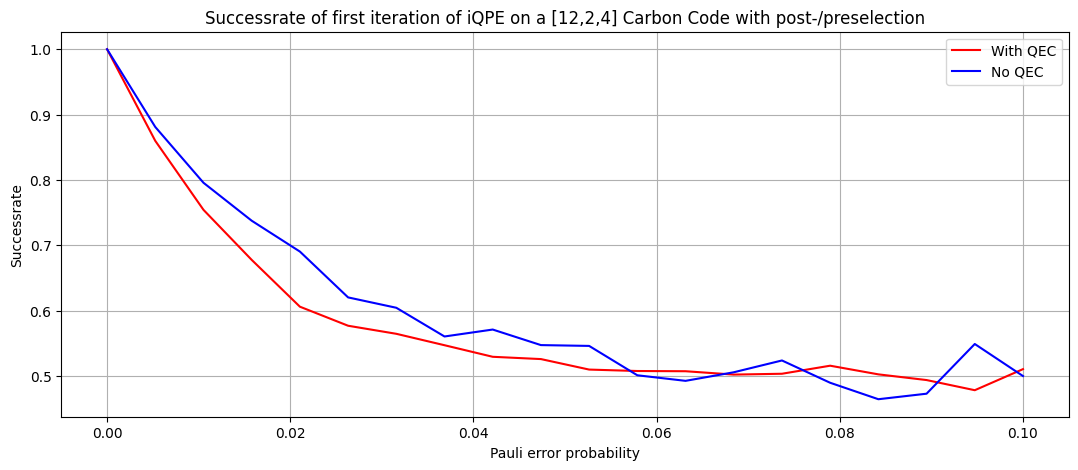

In [154]:
x = np.linspace(0,0.1,20)
y = []
y_no_QEC = []
shots = 10000
pre,pre_no_QEC, post, post_no_QEC = [],[],[],[]
data_raw = np.array([0 for i in range(12)])
for i in x:
    # depolarizing_prob = i
    # dep_error = depolarizing_error(depolarizing_prob, 1)
    # dep_error_2q = depolarizing_error(depolarizing_prob, 2)
    # noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h'])  # Apply to single-qubit gates
    # noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates
    
    qc, q = code()

    X_L(qc, q, 1)

    H_L(qc, q, 0)

    CZ_L(qc, q)

    H_L(qc, q, 0)

    #CNOT_L(qc, q, 1)

    result = readout(qc, shots, q, i)

    nice, total = result[4] + result[5], result[2] + result[3] + result[4] + result[5]

    if total == 0:
        y_no_QEC.append(0.5)
    else:
        y_no_QEC.append(nice/total)
    
    pre_no_QEC.append(result[0]/100)
    post_no_QEC.append(result[1]/100)

    ###############################################################################################################
    qc, q = code()

    qec_ideal(qc, q)

    H_L(qc, q, 0)

    qec_ideal(qc, q)

    X_L(qc, q, 1)

    qec_ideal(qc, q)

    H_L(qc, q, 0)
    qec_ideal(qc, q)
    CNOT_L(qc, q, 1)
    H_L(qc, q, 0)

    qec_ideal(qc, q)

    H_L(qc, q, 0)

    qec_ideal(qc, q)

    result_1 = readout(qc, shots, q, i)

    nice, total = result_1[4] + result_1[5], result_1[2] + result_1[3] + result_1[4] + result_1[5]

    if total == 0:
        y.append(0.5)
    else:
        y.append(nice/total)
    pre.append(result_1[0]/100)
    post.append(result_1[1]/100)

    hmm = result + result_1
    data_raw = np.vstack([data_raw,hmm])

data = np.array((pre,pre_no_QEC,post,post_no_QEC,x,y,y_no_QEC))
#np.savetxt("Plots/text/Carbon_1st_depol_10k.txt", data, delimiter=",")
# x_1 = np.insert(x, 0, 0)
# x_1 = np.transpose(x_1)
# data_raw = np.hstack([data_raw,x_1])
np.savetxt("Plots/text/RAW_Carbon_1st_Pauli_10k.txt", data_raw, delimiter=",")

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(x,y,label = "With QEC", color="red")
ax.plot(x,y_no_QEC,label = "No QEC", color="blue")
plt.title("Successrate of first iteration of iQPE on a [12,2,4] Carbon Code with post-/preselection")
plt.xlabel("Pauli error probability")
plt.ylabel("Successrate")
plt.grid()
plt.legend()
plt.show()

In [21]:
qc, q = code()                      #92,4

qec_ideal(qc, q)

H_L(qc, q, 0)
qec_ideal(qc, q)

X_L(qc, q, 1)
qec_ideal(qc, q)

T_L(qc, q, 0)
qec_ideal(qc, q)
T_L(qc, q, 1)
qec_ideal(qc, q)
CNOT_L(qc, q, 0)
adj_T_L(qc, q, 1)
qec_ideal(qc, q)
CNOT_L(qc, q, 0)

adj_S_L(qc, q, 0)
qec_ideal(qc, q)

H_L(qc, q, 0)
qec_ideal(qc, q)

result = readout(qc, 1000, q, 0.005)

print("Preselected: ", result[0], "%")
print("Postselected: ", result[1], "%")
print("00: ", result[2], "%")
print("01: ", result[3], "%")
print("10: ", result[4], "%")
print("11: ", result[5], "%")

print("Succesrate: ", (result[2]+ result[3])/(result[5]+result[3]+result[2]+result[4]))

#qc.draw("mpl")

Preselected:  16.8 %
Postselected:  0.6 %
00:  0.0 %
01:  73.4 %
10:  0.0 %
11:  9.2 %
Succesrate:  0.8886198547215496


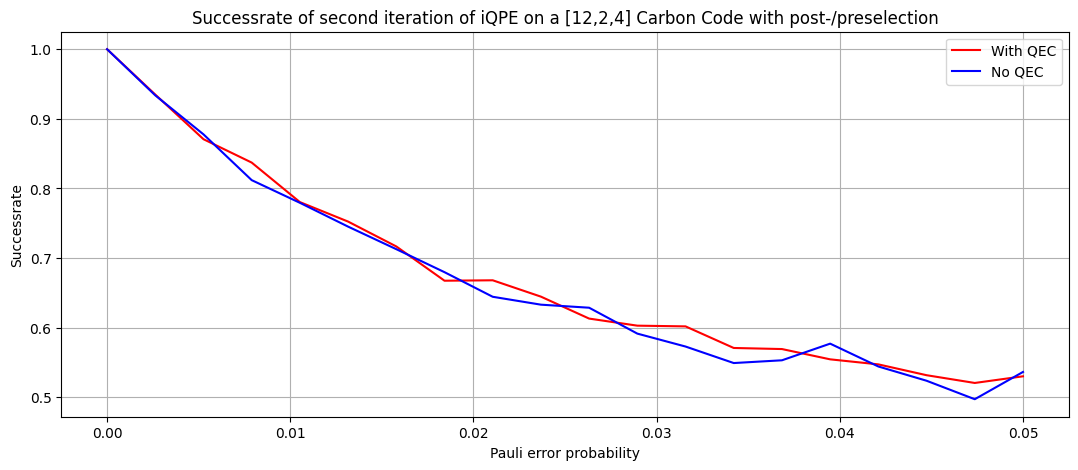

In [155]:
x = np.linspace(0,0.05,20)
y = []
y_no_QEC = []
pre,pre_no_QEC, post, post_no_QEC = [],[],[],[]
data_raw = np.array([0 for i in range(12)])
shots = 10000
for i in x:
    # depolarizing_prob = i
    # dep_error = depolarizing_error(depolarizing_prob, 1)
    # dep_error_2q = depolarizing_error(depolarizing_prob, 2)
    # noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(dep_error, ['x', "z",'h'])  # Apply to single-qubit gates
    # noise_model.add_all_qubit_quantum_error(dep_error_2q, ["cx"])  # Apply to 2-qubit gates
    
    qc, q = code()

    H_L(qc, q, 0)

    X_L(qc, q, 1)

    CS_L(qc, q)
    adj_S_L(qc, q, 0)

    H_L(qc, q, 0)

    #CNOT_L(qc, q, 1)

    result = readout(qc, shots, q, i)

    nice, total = result[2] + result[3], result[2] + result[3] + result[4] + result[5]

    if total == 0:
        y_no_QEC.append(0.5)
    else:
        y_no_QEC.append(nice/total)
    pre_no_QEC.append(result[0]/100)
    post_no_QEC.append(result[1]/100)

    ###############################################################################################################

    qc, q = code()                      #92,4

    qec_ideal(qc, q)

    H_L(qc, q, 0)
    qec_ideal(qc, q)

    X_L(qc, q, 1)
    qec_ideal(qc, q)

    T_L(qc, q, 0)
    qec_ideal(qc, q)
    T_L(qc, q, 1)
    qec_ideal(qc, q)
    CNOT_L(qc, q, 0)
    adj_T_L(qc, q, 1)
    qec_ideal(qc, q)
    CNOT_L(qc, q, 0)

    adj_S_L(qc, q, 0)
    qec_ideal(qc, q)

    H_L(qc, q, 0)
    qec_ideal(qc, q)


    result_1 = readout(qc, shots, q, i)

    nice, total = result_1[2] + result_1[3], result_1[2] + result_1[3] + result_1[4] + result_1[5]

    if total == 0:
        y.append(0.5)
    else:
        y.append(nice/total)

    pre.append(result_1[0]/100)
    post.append(result_1[1]/100)

    hmm = result + result_1
    data_raw = np.vstack([data_raw,hmm])

data = np.array((pre,pre_no_QEC,post,post_no_QEC,x,y,y_no_QEC))
#np.savetxt("Plots/text/Carbon_2nd_depol_10k.txt", data, delimiter=",")
np.savetxt("Plots/text/RAW_Carbon_2nd_Pauli_10k.txt", data_raw, delimiter=",")

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(x,y,label = "With QEC", color="red")
ax.plot(x,y_no_QEC,label = "No QEC", color="blue")
plt.title("Successrate of second iteration of iQPE on a [12,2,4] Carbon Code with post-/preselection")
plt.xlabel("Pauli error probability")
plt.ylabel("Successrate")
plt.grid()
plt.legend()
plt.show()

[[0.00000000e+00 5.26315789e-04 1.05263158e-03 1.57894737e-03
  2.10526316e-03 2.63157895e-03 3.15789474e-03 3.68421053e-03
  4.21052632e-03 4.73684211e-03 5.26315789e-03 5.78947368e-03
  6.31578947e-03 6.84210526e-03 7.36842105e-03 7.89473684e-03
  8.42105263e-03 8.94736842e-03 9.47368421e-03 1.00000000e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.0

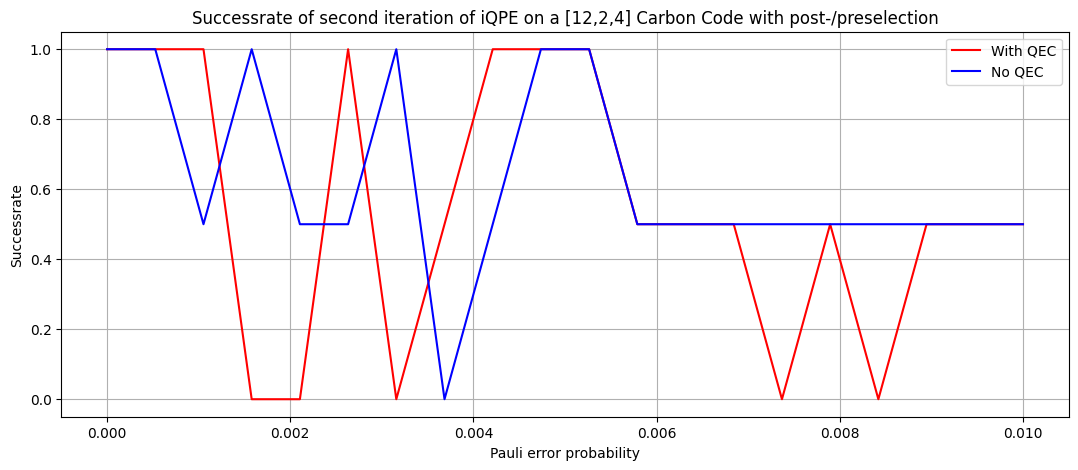

In [ ]:
x = np.linspace(0,0.01,20)
y = []
y_no_QEC = []
pre, post, nn, ne, en, ee, pre2, two, post2, nn2, ne2, ee2, en2 = [],[],[],[],[],[],[],[],[],[],[],[],[]
shots = 1
for i in x:
    qc, q, tracker = code_test(0)

    n = [0]
    X_L(qc, q, 1)
    H_L(qc, q, 0)
    CT_L(qc, q, n, tracker, False)
    adj_T_L(qc, q, 0)
    H_L(qc, q, 0)

    counts, cbits = readout_2(qc, shots, q, i)

    result = fullpp(counts, shots, cbits, tracker, False)

    nice, total = result[3] + result[4], result[3] + result[6] + result[4] + result[5]
    if total == 0:
        y_no_QEC.append(0.5)
    else:
        y_no_QEC.append(nice/total)

    pre.append(result[0]), post.append(result[2]), nn.append(result[3]), ne.append(result[4]), en.append(result[5]), ee.append(result[6])

    ###############################################################################################################

    qc, q, tracker = code_test(32)

    n = [0]
    X_L(qc, q, 1)
    qec_ideal(qc, q, n, tracker)
    H_L(qc, q, 0)
    qec_ideal(qc, q, n, tracker)
    CT_L(qc, q, n, tracker, True)
    qec_ideal(qc, q, n, tracker)
    adj_T_L(qc, q, 0)
    qec_ideal(qc, q, n, tracker)
    H_L(qc, q, 0)


    counts, cbits = readout_2(qc, shots, q, i)

    result_1 = fullpp(counts, shots, cbits, tracker)

    nice, total = result_1[3] + result_1[4], result_1[6] + result_1[3] + result_1[4] + result_1[5]

    if total == 0:
        y.append(0.5)
    else:
        y.append(nice/total)

    pre2.append(result_1[0]), two.append(result_1[1]), post2.append(result_1[2]), nn2.append(result_1[3]), ne2.append(result_1[4]), en2.append(result_1[5]), ee2.append(result_1[6])

data = np.array((x,pre,post,nn,ne,en,ee,pre2,two,post2,nn2,ne2,en2,ee2))
#np.savetxt("Plots/text/Carbon_2nd_depol_10k.txt", data, delimiter=",")
#np.savetxt("Plots/text/RAW_Carbon_2nd_Pauli_10k.txt", data_raw, delimiter=",")

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(x,y,label = "With QEC", color="red")
ax.plot(x,y_no_QEC,label = "No QEC", color="blue")
plt.title("Successrate of second iteration of iQPE on a [12,2,4] Carbon Code with post-/preselection")
plt.xlabel("Pauli error probability")
plt.ylabel("Successrate")
plt.grid()
plt.legend()
plt.show()